In [1]:
# https://github.com/franchyze923/Code_From_Tutorials/blob/master/Strava_Api/strava_api.py
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
import numpy as np
import matplotlib.pyplot as plt
import polyline
import pandas as pd
from datetime import datetime, date
from matplotlib.dates import date2num, num2date
import ipywidgets as widgets
from matplotlib import animation
%matplotlib widget

### Download data using API

In [2]:
auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': open('client_id', 'r').read(),
    'client_secret': open('client_secret', 'r').read(),
    'refresh_token': open('refresh_token', 'r').read(),
    'grant_type': "refresh_token",
    'f': 'json'
}

res = requests.post(auth_url, data=payload, verify=False)
access_token = res.json()['access_token']
header = {'Authorization': 'Bearer ' + access_token}

param = {'per_page': 200, 'page': 3}
my_dataset = requests.get(activites_url, headers=header, params=param).json()

# Loop through pages
my_dataset = []
page = 1
len_page_data = 1
while len_page_data > 0:
    param = {'per_page': 200, 'page': page}
    page_data = requests.get(activites_url, headers=header, params=param).json()
    len_page_data = len(page_data)
    my_dataset.extend(page_data)
    page += 1

print(len(my_dataset))

342


### Organise data

In [3]:
# Convert to dataframe
activities = pd.json_normalize(my_dataset)

# Keep the interesting columns
activities = activities[['name', 'distance', 'moving_time', 'elapsed_time', 'total_elevation_gain', 'type', 'start_date_local',
                           'average_speed', 'elev_high', 'elev_low',  'map.summary_polyline']]

# Convert dates/times
activities['start_date_local'] = pd.to_datetime(activities['start_date_local'])
activities['start_time'] = activities['start_date_local'].dt.time
activities['start_date_local'] = activities['start_date_local'].dt.date
activities.sort_values(by='start_date_local', ascending=True, inplace=True, ignore_index=True)
# activities.head()

### Plot runs

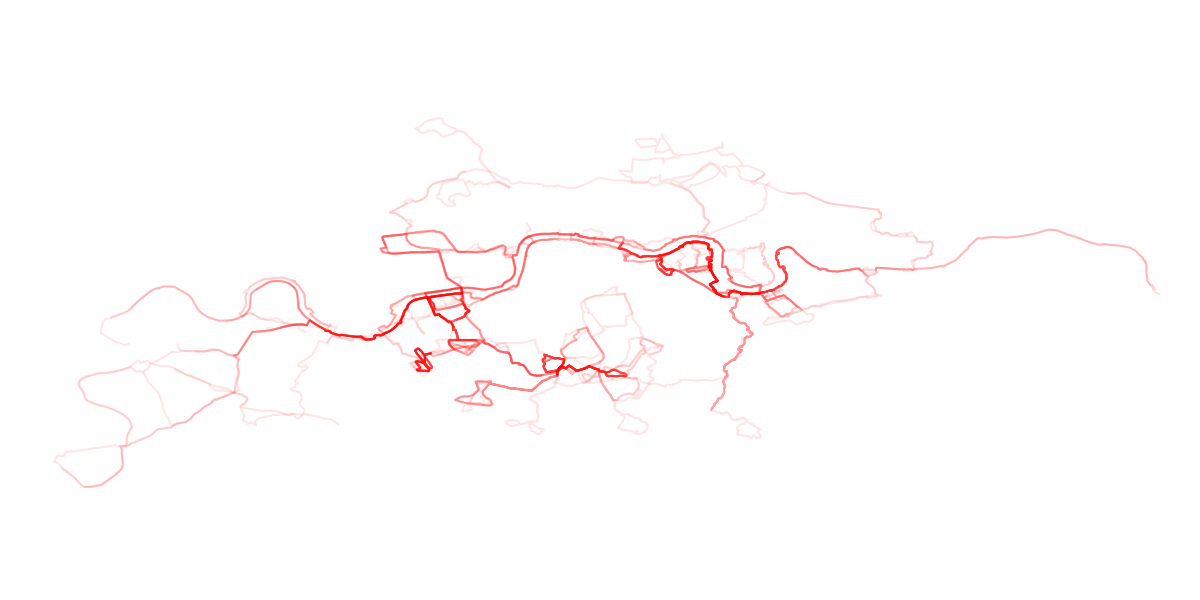

In [7]:
# Set up plot
fig, ax = plt.subplots()
ax.axis('off')
fig.set_size_inches(12,6)
fig.tight_layout()

# Rough London Boundaries
ax.set_xlim(-3.6e-6, 1.9e-6)
ax.set_ylim(5.136e-4, 5.160e-4)
ax.set_aspect('equal')

# Plot runs
for p in activities[activities.type == 'Run']['map.summary_polyline']:
    coordinates = polyline.decode(p, 10)
    longitudes = [coordinate[1] for coordinate in coordinates]
    latitudes = [coordinate[0] for coordinate in coordinates]
    ax.plot(longitudes, latitudes, 'r-', alpha=0.1)


### Slider plot

interactive(children=(FloatSlider(value=17434.0, description='slider_date', max=19574.0, min=17434.0, step=1.0…

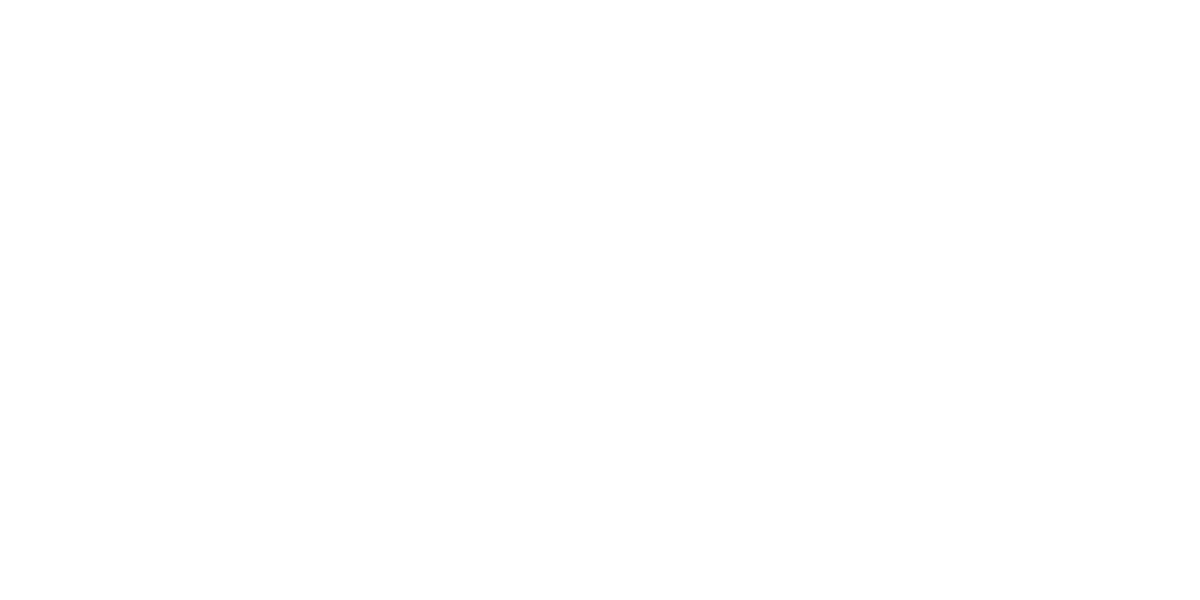

In [8]:
# Set up plot
fig, ax = plt.subplots()
ax.axis('off')
fig.set_size_inches(12,6)
fig.tight_layout()

# Rough London Boundaries
ax.set_xlim(-3.8e-6, 2e-6)
ax.set_ylim(5.136e-4, 5.160e-4)
ax.set_aspect('equal')

# Plot runs
for p in activities[activities.type == 'Run']['map.summary_polyline']:
    coordinates = polyline.decode(p, 10)
    longitudes = [coordinate[1] for coordinate in coordinates]
    latitudes = [coordinate[0] for coordinate in coordinates]
    ax.plot(longitudes, latitudes, 'r-', alpha=0.1)

# Animate
start = date2num(activities.iloc[0].start_date_local) - 1
@widgets.interact(slider_date=(start, date2num(date.today()), 1))
def update(slider_date=start):
    for d, l in zip(date2num(activities.start_date_local), ax.lines):
        if d <= slider_date:
            l.set_visible(True)
        else:
            l.set_visible(False)
    

### Animation

In [9]:
# # Set up plot
# fig, ax = plt.subplots()
# ax.axis('off')
# fig.set_size_inches(12,6)
# fig.tight_layout()

# # Rough London Boundaries
# ax.set_xlim(-3.8e-6, 2e-6)
# ax.set_ylim(5.136e-4, 5.160e-4)
# ax.set_aspect('equal')

# # Plot runs
# for p in activities[activities.type == 'Run']['map.summary_polyline']:
#     coordinates = polyline.decode(p, 10)
#     longitudes = [coordinate[1] for coordinate in coordinates]
#     latitudes = [coordinate[0] for coordinate in coordinates]
#     ax.plot(longitudes, latitudes, 'r-', alpha=0.1)

# # Update function
# def update(slider_date):
#     for d, l in zip(date2num(activities.start_date_local), ax.lines):
#         if d <= slider_date:
#             l.set_visible(True)
#         else:
#             l.set_visible(False)
# 
# # Animation
# frames = np.arange(date2num(activities.iloc[0].start_date_local), date2num(date.today()), 10)
# anim = animation.FuncAnimation(fig, update, frames=iter(frames), save_count=len(frames))
# writer = animation.writers['ffmpeg']
# writer = writer(fps=24, bitrate=-1)
# anim.save('animation.gif', writer=writer, dpi=300)